### Main goals:
✅ Clarify and reflect on the definition of the term "fake news", which may vary among databases, sometimes non-binary.\
✅ Research, where the data comes from and inspect the data: what are the labels, sources, and authors?\
Is there a person, source or topic which is over- or under-represented?\
✅ Study the literature on how others approach this task. Check the related literature and select your model architecture of choice: LSTM, ...\
✅ Develop a classification model to predict fake news from the text. How do you judge the quality of your results, i.e. which metrics do you consider?
### Optional:
Inspect the falsely classified ones. What can you learn from them?\
Investigate edge cases that you found in your data inspection with respect to how the model learned to identify these.\
Experiment with how you could mitigate if edge cases are covered poorly.

In [135]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments,Trainer, pipeline
from datasets import load_dataset
import numpy as np
import evaluate
from sklearn.metrics import classification_report
from bertviz import model_view,head_view
import shap
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
from berttopic import BERTTopic


from nltk import ne_chunk, pos_tag, word_tokenize
import nltk
nltk.download('maxent_ne_chunker')
nltk.download('words')

ModuleNotFoundError: No module named 'berttopic'

## Model Training

#### Downloading the base model and getting the tokenizer
The code below is not necessary to run, as we fine-tuned the model and uploaded it to HuggingFace, therefore just go down to the Model inspection part.

In [ ]:
# model_name = "google-bert/bert-base-uncased"

In [ ]:
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# def tokenize_function(examples):
#     return tokenizer(examples["text"], padding="max_length", truncation=True)

#### Loading the data set

In [ ]:
# data = load_dataset('GonzaloA/fake_news')

In [ ]:
# data = data.remove_columns(['Unnamed: 0','title'])

In [ ]:
# tokenized_data = data.map(tokenize_function, batched=True)

#### Sampling from the data set

In [ ]:
# small_train_dataset = tokenized_data["train"].shuffle(seed=42).select(range(100))
# small_eval_dataset = tokenized_data["validation"].shuffle(seed=42).select(range(100))
# small_test_dataset = tokenized_data['test']

#### Outputting the training arguments

In [ ]:
# training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

#### Loading the evaluation metrics

In [ ]:
# metric = evaluate.load("accuracy")

In [ ]:
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)

#### Initializing the Trainer object and fine-tuning the model

In [ ]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=small_train_dataset,
#     eval_dataset=small_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [ ]:
# trainer.train()

#### Getting the predictions

In [ ]:
# test_labels = small_test_dataset['label']
# small_test_dataset = small_test_dataset.remove_columns(['label','token_type_ids'])

In [ ]:
# predictions = trainer.predict(small_test_dataset)

In [ ]:
# predicted_labels = predictions.predictions.argmax(axis=1)

#### Saving the model

In [ ]:
# trainer.save_model('bert-base-uncased-fake-news-classification')

In [ ]:
# tokenizer.save_pretrained('bert-base-uncased-fake-news-classification')

#### Saving the predictions

In [ ]:
# with open('predictions/predictions.txt', 'w') as f:
#     for line in predicted_labels:
#         f.write(f"{line}\n")

## Model Inspection

In [72]:
load_dotenv()

True

#### Loading the model

In [73]:
model_name = 'Flo335/bert-base-uncased-fake-news-classification'

In [74]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2,output_attentions = True,token = os.getenv('huggingface'))

In [75]:
tokenizer = AutoTokenizer.from_pretrained(model_name,token = os.getenv('huggingface'))

#### Loading the dataset

In [76]:
data = load_dataset('GonzaloA/fake_news')

Repo card metadata block was not found. Setting CardData to empty.


In [87]:
data

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'label'],
        num_rows: 24353
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'label'],
        num_rows: 8117
    })
    test: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'label'],
        num_rows: 8117
    })
})

In [96]:
data['train']['text'][2]

'MOSCOW (Reuters) - Russia on Wednesday warned Iraq and the Kurds against taking any steps that might destabilize the Middle East after a Kurdish independence referendum, encouraging both sides to hold talks to find a solution within the framework of a single Iraqi state. The Russian Foreign Ministry, in the same statement, also said that while Moscow respected the Kurds  national ambitions it favored preserving the territorial integrity of Iraq. '

In [97]:
data['train']['title'][2]

'Russia warns Iraq, Kurds not to destabilize Middle East after Kurdish vote'

In [98]:
data = data.remove_columns(['Unnamed: 0','title'])

In [99]:
with open('predictions/predictions.txt','r') as f:
    predictions = f.read().split('\n')

predictions = [int(i) for i in predictions]

#### Evaluating the predictions

In [100]:
print(classification_report(data['test']['label'],predictions))

              precision    recall  f1-score   support

           0       0.96      0.86      0.90      3782
           1       0.89      0.97      0.92      4335

    accuracy                           0.92      8117
   macro avg       0.92      0.91      0.91      8117
weighted avg       0.92      0.92      0.92      8117



In [113]:
count = 0
for i,j in zip(predictions,data['test']['label']):
    if i != j:
        print(count)
    count += 1

25
37
46
59
62
70
79
81
85
92
96
106
112
113
175
177
185
196
210
222
233
237
243
248
259
263
264
285
286
299
300
330
337
344
348
357
359
361
363
385
402
430
431
445
451
460
466
476
490
505
536
542
559
580
589
607
659
668
681
684
686
702
712
713
716
726
737
743
747
763
769
770
803
823
827
837
840
841
849
859
871
878
879
890
897
913
919
923
929
957
960
964
970
987
993
1009
1010
1023
1026
1042
1054
1073
1081
1084
1094
1124
1141
1175
1187
1205
1213
1217
1221
1225
1245
1258
1273
1275
1292
1311
1313
1318
1372
1389
1406
1407
1413
1420
1429
1432
1435
1439
1440
1443
1448
1478
1487
1496
1502
1521
1526
1531
1532
1535
1543
1556
1559
1569
1589
1608
1613
1625
1626
1642
1689
1716
1731
1740
1743
1745
1756
1777
1778
1789
1806
1810
1818
1820
1824
1826
1843
1851
1854
1888
1901
1902
1912
1918
1928
1930
1934
1946
1950
1951
1954
1957
1964
1966
1976
1996
2013
2022
2036
2058
2092
2097
2104
2125
2157
2173
2200
2209
2216
2224
2233
2245
2268
2273
2281
2299
2312
2330
2336
2340
2347
2350
2366
2389
2393
2405
2415
2

In [137]:
predictions[59]

1

In [136]:
data['test']['label'][59]

0

#### Exploratory Data Analysis

In [116]:
count_dict = dict()
for i in data:
    true_news = []
    fake_news = []
    for j in data[i]['label']:
        if j == 0:
            fake_news.append(j)
        else:
            true_news.append(j)
    count_dict[i] = (len(fake_news),len(true_news))

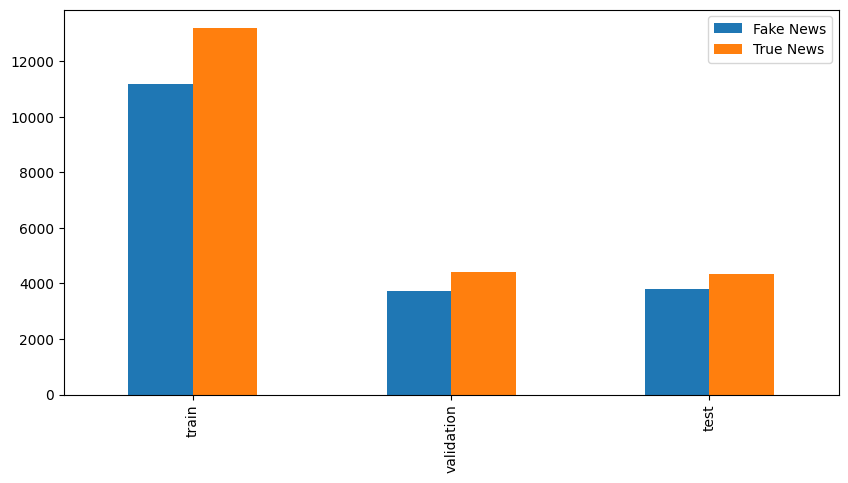

In [117]:
count_df = pd.DataFrame.from_dict(count_dict,orient = 'index')
count_df.rename(columns = {0:'Fake News',1:'True News'},inplace = True)
count_df.plot.bar(figsize = (10,5));

In [118]:
len_count_dict = dict()
for i in data:
    true_news = []
    fake_news = []
    for j in data[i]:
        if j['label'] == 0:
            fake_news.append(len(j['text']))
        else:
            true_news.append(len(j['text']))
    len_count_dict[i] = (np.mean(fake_news),np.mean(true_news))

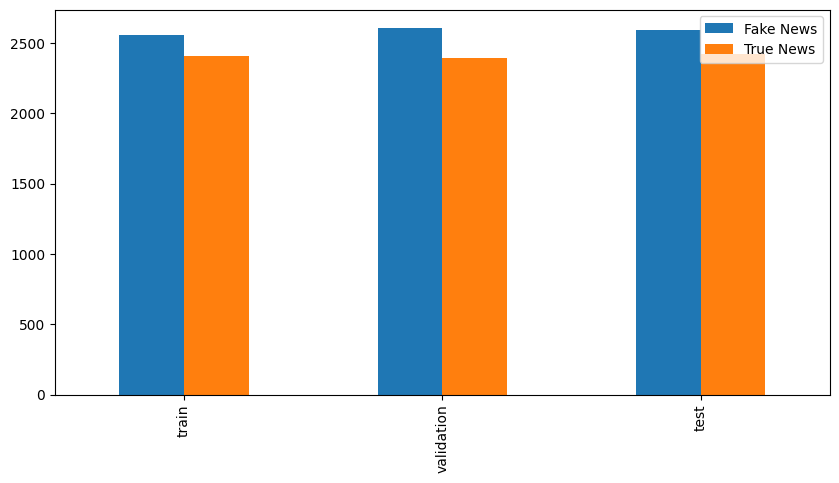

In [119]:
len_count_df = pd.DataFrame.from_dict(len_count_dict,orient = 'index')
len_count_df.rename(columns = {0:'Fake News',1:'True News'},inplace = True)
len_count_df.plot.bar(figsize = (10,5));

In [120]:
# tokenizer.get_vocab()

#### Inspecting over-represented tokens and named entities in our corpus

In [ ]:
def compute_ratios(first: list, other: list) -> dict:
    '''
    returns the frequency for each element in first divided by its frequency in other
        - meant to show which elements are overrepresented in first compared to other
    '''
    first_counts = Counter(first)
    other_counts = Counter(other)

    ratios = {}

    for item in first_counts:
        if item in other_counts:
            ratios[item] = first_counts[item] / other_counts[item]
        else:
            # to avoid division by zero, pretends items absent in other occur once instead
            ratios[item] = first_counts[item] 

    return ratios

In [ ]:
# splits up data by label
fake = []
true = []
for article in data['train']:
    if article['label'] == 1: # label == true
        true.append(article)
    else:# label == fake
        fake.append(article)


# merges and tokenizes the text of the fake/non-fake news
true_combined = ' '.join([article['text'] for article in true])
fake_combined = ' '.join([article['text'] for article in fake])
true_tokens = word_tokenize(true_combined)
fake_tokens = word_tokenize(fake_combined)

# computes token frequency in fake news / frequency in non-fake news (and vice versa) and sorts by ratio
true_ratios = compute_ratios(true_tokens, fake_tokens)
fake_ratios = compute_ratios(fake_tokens, true_tokens)
true_ratios_sorted = sorted(list(true_ratios.items()), key=lambda x: x[1], reverse=True)
fake_ratios_sorted = sorted(list(fake_ratios.items()), key=lambda x: x[1], reverse=True)

In [ ]:
# prepares token ratios for plotting

# only plots top 10 highest ratios
n_tokens = 10

x_true = [token for token, _  in true_ratios_sorted[:n_tokens]]
x_fake = [token for token, _  in fake_ratios_sorted[:n_tokens]]
x_true.reverse()
x_fake.reverse()

y_true = [ratio for _, ratio in true_ratios_sorted[:n_tokens]]
y_fake = [ratio for _, ratio in fake_ratios_sorted[:n_tokens]]
y_true.reverse()
y_fake.reverse()

In [ ]:
# samples article to save compute time on the following
size = 400
fake_sample = np.random.choice(fake, size=size)
true_sample = np.random.choice(true, size=size)

# does NER on non-fake news, storing all named entities in list
true_NE = []
true_combined = ' '.join([article['text'] for article in true_sample])
tags = pos_tag(word_tokenize(true_combined))
chunks = ne_chunk(tags)
n_chunks = len(chunks)
for i, chunk in enumerate(chunks):
    if hasattr(chunk, 'label'):
        true_NE.append(' '.join([word[0] for word in chunk]))

# does NER on fake news, storing all named entities in list
fake_NE = []
fake_combined = ' '.join([article['text'] for article in fake_sample])
tags = pos_tag(word_tokenize(fake_combined))
chunks = ne_chunk(tags)
n_chunks = len(chunks)
for i, chunk in enumerate(chunks):
    if hasattr(chunk, 'label'):
        fake_NE.append(' '.join([word[0] for word in chunk]))


# computes named entity frequency in fake news / frequency in non-fake news (and vice versa) and sorts by ratio
true_ratios_NE = compute_ratios(true_NE, fake_NE)
fake_ratios_NE = compute_ratios(fake_NE, true_NE)
true_ratios_sorted_NE = sorted(list(true_ratios_NE.items()), key=lambda x: x[1], reverse=True)
fake_ratios_sorted_NE = sorted(list(fake_ratios_NE.items()), key=lambda x: x[1], reverse=True)

In [ ]:
# prepares named entity ratios for plotting

# only plots top 10 highest ratios
n_entities = 10

x_true_NE = [entities for entities, _  in true_ratios_sorted_NE[:n_entities]]
x_fake_NE = [entities for entities, _  in fake_ratios_sorted_NE[:n_entities]]
x_true_NE.reverse()
x_fake_NE.reverse()

y_true_NE = [ratio for _, ratio in true_ratios_sorted_NE[:n_entities]]
y_fake_NE = [ratio for _, ratio in fake_ratios_sorted_NE[:n_entities]]
y_true_NE.reverse()
y_fake_NE.reverse()

In [ ]:
# plots all the ratios
fig, axs = plt.subplots(figsize=(12,8), nrows=2, ncols=2)

axs = axs.flatten()

axs[0].barh(x_true, y_true)
axs[0].set_title('Tokens overrepresented in non-fake news')

axs[1].barh(x_fake, y_fake)
axs[1].set_title('Tokens overrepresented in fake news')

axs[2].barh(x_true_NE, y_true_NE)
axs[2].set_title('Entities overrepresented in non-fake news')

axs[3].barh(x_fake_NE, y_fake_NE)
axs[3].set_title('Entities overrepresented in fake news')


fig.tight_layout()
fig.show()

#### Inspecting the model and the head

In [121]:
inputs = tokenizer.encode(data['test'][9]['text'], return_tensors='pt')
outputs = model(inputs)
attention = outputs[-1]  # Output includes attention weights when output_attentions=True
tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 

In [122]:
# head_view(attention, tokens)

In [123]:
# model_view(attention, tokens)

#### Inspecting the model's attention

In [128]:
pipe = pipeline('text-classification',model=model_name, top_k=None)

In [129]:
explainer = shap.Explainer(pipe)

In [ ]:
# 0 - Fake | 1 - True

In [133]:
# labeled as True (1) but actually Fake (0)
shap_values = explainer([data['test'][59]['text']])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [03:39, 219.16s/it]              


In [134]:
shap.plots.text(shap_values)